In [1]:
import qutip as qt
import numpy as np
from scipy.stats import unitary_group
import random

import matplotlib.pyplot as plt

import cirq
from cirq.ops import common_gates, raw_types
from cirq.sim import wave_function
from tqdm import tqdm_notebook as tqdm

import networkx as nx

import pandas as pd

# Defining the circuit

For simplicity, we will assume that d = 1.

In [2]:
def q(xs):
    return [cirq.LineQubit(x) for x in xs]

In [3]:
# For some reason cirq.I is not invertible

class IdGate(cirq.IdentityGate):
    def __init__(self, num_qubits):
        super().__init__(num_qubits)
    
    def __pow__(self, n):
        return IdGate(self._num_qubits)


In [4]:
IdG = IdGate(1)

In [5]:
# Generate a random unitary

class RandomUnitaryGate(cirq.TwoQubitMatrixGate):
    
    def __init__(self, random_state = None, *, _random_gate = None):
        if _random_gate is None:
            mat = unitary_group.rvs(4, random_state = random_state)
        else:
            mat = _random_gate
        super().__init__(mat)
    
    def __pow__(self, n):
        if n == -1:
            mat = np.matrix(self._matrix).H
            return RandomUnitaryGate(_random_gate = np.array(mat))
    
    def __str__(self):
        return 'Rnd'
    
    def _circuit_diagram_info_(self, args):
        return 'Rnd1', 'Rnd2'
    

In [6]:
simulator = cirq.DensityMatrixSimulator()

In [7]:
def random_slice(support, start = None):
    if start is None:
        start = random.randint(0,1)
    if start not in [0, 1]:
        raise ValueError('Needs to be 0, 1, or None.')

    if start == 1:
        yield IdG(support[0])
        
    for i in range(start, len(support) - 1, 2):
        r = RandomUnitaryGate()
        yield r(support[i], support[i+1])
    if (len(support) - start) % 2 == 1:
        yield IdG(support[-1])

In [8]:
def next_support(support, D, N, layer_num):
    lowest = support[0].x
    highest = support[-1].x
    
    current_multiple = 2 ** layer_num
    
    # first available not in the circuit
    next_lowest = ((lowest - 1) // current_multiple)*current_multiple
    next_highest = (highest // current_multiple + 1)*current_multiple
    
    new_support = [qubit for qubit in support]
    
    for i in range(D):
        if next_lowest > 0:
            new_support.insert(0, cirq.LineQubit(next_lowest))
            next_lowest -= current_multiple
        
        if next_highest <= N:
            new_support.append(cirq.LineQubit(next_highest))
            next_highest += current_multiple
            
    return new_support

In [9]:
def support_per_layer(initial_support, D, N):
    support = initial_support
    i = 0 
    supports = []
    while len(support) != 0:
        new_support = next_support(support, D, N, i)
        i += 1
        
        supports.append((support, new_support))
        support = list(filter(lambda q: q.x % (2 ** i) == 0, new_support))
        
    return supports

In [10]:
def random_layer(support, goal_support, D):
    slices = []
    support_set = set(goal_support)
    circuit = cirq.Circuit()
    
    for i in range(D):
        single_slice = list(random_slice(support, ( i) % 2))
        single_slice = [gate for gate in single_slice if any(map(lambda q: q in support_set, gate.qubits))]
        
        for gate in single_slice:
            for qubit in gate.qubits:
                support_set.add(qubit)
        
        slices.append(single_slice)
    
    for single_slice in slices[::-1]:
        circuit.append(single_slice, strategy = cirq.InsertStrategy.NEW_THEN_INLINE)
    
    return circuit

In [11]:
def fix_circuit(circuit, support, goal_support, num_layer):
    new_circuit = cirq.Circuit()
    current_multiple = 2**num_layer
    inserted = [qubit for qubit in support if qubit.x % (current_multiple * 2) != 0]
    
    if len(inserted) < len(goal_support):
        return circuit, None
    
    real_qubit = {q: q for q in support}    
    goal_qubit = {nq: sq for nq, sq in zip(inserted, goal_support)}
    
    for moment in circuit:
        new_moment = []
        for gate in moment:
            new_moment.append(gate.gate(*[real_qubit[q] for q in gate.qubits]))
        
        for gate in moment:
            if len(gate.qubits) != 2:
                continue
                
            a, b = gate.qubits[0], gate.qubits[1]

            disStatusQuo = abs(a.x - goal_qubit.get(real_qubit[a], a).x) + abs(b.x - goal_qubit.get(real_qubit[b], b).x)
            disAlternative = abs(b.x - goal_qubit.get(real_qubit[a], b).x) + abs(a.x - goal_qubit.get(real_qubit[b], a).x)
            
            
            if disAlternative < disStatusQuo:
                new_moment.append(cirq.SWAP(real_qubit[a], real_qubit[b]))
                real_qubit[a], real_qubit[b] = real_qubit[b], real_qubit[a]  
        
        new_circuit.append(new_moment, strategy = cirq.InsertStrategy.NEW_THEN_INLINE)
    
    new_goal = [real_qubit[qubit] for qubit in goal_support]
    
    return new_circuit, new_goal

In [12]:
def random_circuit(support, D, N):
    # Ideally must have |support| = 2D - 1 continuous
    supports = support_per_layer(support, D, N)
    
    circuits = []
    for i, (goal_support, support) in enumerate(supports):
        circuit = random_layer(support, goal_support, D)
        if i == 0:
            # Only need to rewrite the last one/the ones that are traced out
            circuit, new_goal = fix_circuit(circuit, sorted(list(circuit.all_qubits())), goal_support, i)
        else:
            # Only need to rewrite the last one/the ones that are traced out
            circuit, alt_goal = fix_circuit(circuit, sorted(list(circuit.all_qubits())), goal_support, i)
            #print(alt_goal, goal_support)
            if alt_goal:
                swaps = [cirq.SWAP(alt, orig) for alt, orig in zip(alt_goal, goal_support) if alt != orig]

                circuit.append(swaps, strategy = cirq.InsertStrategy.NEW_THEN_INLINE)
        circuits.append(circuit)
    return circuits[::-1], new_goal
    

In [13]:
def random_circuit_no_fix(support, D, N):
    # Ideally must have |support| = 2D - 1 continuous
    supports = support_per_layer(support, D, N)
    
    circuits = []
    for i, (goal_support, support) in enumerate(supports):
        circuit = random_layer(support, goal_support, D)
        circuits.append(circuit)
    return circuits[::-1]
    

In [14]:
def random_circuit_both_returns(support, D, N):
    # Ideally must have |support| = 2D - 1 continuous
    supports = support_per_layer(support, D, N)
    
    circuitsA = []
    circuitsB = []
    new_goal = None
    for i, (goal_support, support) in enumerate(supports):
        circuit = random_layer(support, goal_support, D)
        circuitsA.append(circuit)
        if i == 0:
            # Only need to rewrite the last one/the ones that are traced out
            circuit, new_goal = fix_circuit(circuit, sorted(list(circuit.all_qubits())), goal_support, i)
        circuitsB.append(circuit)

    return circuitsA[::-1], circuitsB[::-1], new_goal
    

## Testing validity

In [15]:
random_circuit(q([101,102,103]), 3, 128)[1]

[cirq.LineQubit(99), cirq.LineQubit(101), cirq.LineQubit(103)]

In [16]:
cirq.Circuit.from_ops(random_circuit_no_fix(q([1,2,3]), 3, 128))

1: ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Rnd1───I──────Rnd1───
                                                                                                                                               │             │
2: ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Rnd1───I──────Rnd1───Rnd2───Rnd1───Rnd2───
                                                                                                                          │             │             │
3: ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────────┼──────Rnd1───Rnd2───Rnd1───
                                                                                                                          │             │      │             │
4: ──────────────────────────────────────────────────────────────────────────────────────────────────Rnd1───I──────Rnd1───Rnd2───Rnd1───Rnd2───Rnd2───Rnd1───Rnd2───
                                                                                                     │             │             │                    │
5: ──────────────────────────────────────────────────────────────────────────────────────────────────┼─────────────┼─────────────┼─────────────Rnd1───Rnd2──────────
                                                                                                     │             │             │             │
6: ──────────────────────────────────────────────────────────────────────────────────────────────────┼─────────────┼──────Rnd1───Rnd2───Rnd1───Rnd2─────────────────
                                                                                                     │             │      │             │
8: ─────────────────────────────────────────────────────────────────────────────Rnd1───I──────Rnd1───Rnd2───Rnd1───Rnd2───Rnd2───Rnd1───Rnd2────────────────────────
                                                                                │             │             │                    │
10: ────────────────────────────────────────────────────────────────────────────┼─────────────┼─────────────┼─────────────Rnd1───Rnd2───────────────────────────────
                                                                                │             │             │             │
12: ────────────────────────────────────────────────────────────────────────────┼─────────────┼──────Rnd1───Rnd2───Rnd1───Rnd2──────────────────────────────────────
                                                                                │             │      │             │
16: ───────────────────────────────────────────────────────Rnd1───I──────Rnd1───Rnd2───Rnd1───Rnd2───Rnd2───Rnd1───Rnd2─────────────────────────────────────────────
                                                           │             │             │                    │
20: ───────────────────────────────────────────────────────┼─────────────┼─────────────┼─────────────Rnd1───Rnd2────────────────────────────────────────────────────
                                                           │             │             │             │
24: ───────────────────────────────────────────────────────┼─────────────┼──────Rnd1───Rnd2───Rnd1───Rnd2───────────────────────────────────────────────────────────
                                                           │             │      │             │
32: ──────────────────────────────────Rnd1───I──────Rnd1───Rnd2───Rnd1───Rnd2───Rnd2───Rnd1───Rnd2──────────────────────────────────────────────────────────────────
                                      │             │             │                    │
40: ──────────────────────────────────┼─────────────┼─────────────┼─────────────Rnd1───Rnd2─────────────────────────────────────────────────────────────────────────
               

In [17]:
simulator = cirq.Simulator()

In [18]:
# Test for equality

In [19]:
new_goal

NameError: name 'new_goal' is not defined

In [20]:
qubits = q([101,102,103,104])
regular, fixed, new_goal = random_circuit_both_returns(q([101,102,103,104]), 3, 128)

random_circuit_both_returns(qubits, 2, 128)

([128: ───I───I───,
  64: ────I───Rnd1───
            │
128: ───I───Rnd2───,
  32: ────I──────Rnd1───
               │
64: ────Rnd1───Rnd2───
        │
96: ────Rnd2───Rnd1───
               │
128: ───I──────Rnd2───,
  64: ────Rnd1──────────
        │
80: ────Rnd2───Rnd1───
               │
96: ────Rnd1───Rnd2───
        │
112: ───Rnd2───Rnd1───
               │
128: ───I──────Rnd2───,
  80: ────Rnd1──────────
        │
88: ────Rnd2───Rnd1───
               │
96: ────Rnd1───Rnd2───
        │
104: ───Rnd2───Rnd1───
               │
112: ───Rnd1───Rnd2───
        │
120: ───Rnd2──────────,
  92: ────Rnd1──────────
        │
96: ────Rnd2───Rnd1───
               │
100: ───Rnd1───Rnd2───
        │
104: ───Rnd2───Rnd1───
               │
108: ───Rnd1───Rnd2───
        │
112: ───Rnd2──────────,
  98: ────Rnd1──────────
        │
100: ───Rnd2───Rnd1───
               │
102: ───Rnd1───Rnd2───
        │
104: ───Rnd2───Rnd1───
               │
106: ───Rnd1───Rnd2───
        │
108: ───Rnd2─────────

In [21]:
qubits, new_goal

([cirq.LineQubit(101),
  cirq.LineQubit(102),
  cirq.LineQubit(103),
  cirq.LineQubit(104)],
 [cirq.LineQubit(99),
  cirq.LineQubit(101),
  cirq.LineQubit(103),
  cirq.LineQubit(105)])

In [22]:
regular

[128: ───I───I───I───,
 64: ────Rnd1───I───Rnd1───
        │          │
128: ───Rnd2───I───Rnd2───,
 32: ────Rnd1───I──────Rnd1───
        │             │
64: ────Rnd2───Rnd1───Rnd2───
               │
96: ────Rnd1───Rnd2───Rnd1───
        │             │
128: ───Rnd2───I──────Rnd2───,
 16: ────Rnd1─────────────────
        │
32: ────Rnd2───Rnd1──────────
               │
48: ────Rnd1───Rnd2───Rnd1───
        │             │
64: ────Rnd2───Rnd1───Rnd2───
               │
80: ────Rnd1───Rnd2───Rnd1───
        │             │
96: ────Rnd2───Rnd1───Rnd2───
               │
112: ───Rnd1───Rnd2───Rnd1───
        │             │
128: ───Rnd2───I──────Rnd2───,
 56: ────Rnd1─────────────────
        │
64: ────Rnd2───Rnd1──────────
               │
72: ────Rnd1───Rnd2───Rnd1───
        │             │
80: ────Rnd2───Rnd1───Rnd2───
               │
88: ────Rnd1───Rnd2───Rnd1───
        │             │
96: ────Rnd2───Rnd1───Rnd2───
               │
104: ───Rnd1───Rnd2───Rnd1───
        │         

In [23]:
fixed[-1][0:4]

┌────────┐
98: ────Rnd1────────────────────────
        │
99: ────Rnd2────────Rnd1────────×───
                    │           │
100: ───Rnd1────────Rnd2────────×───
        │
101: ───Rnd2────────Rnd1────────×───
                    │           │
102: ───Rnd1────────Rnd2────────×───
        │
103: ───Rnd2────────Rnd1────────────
                    │
104: ───Rnd1───×────┼───Rnd1────────
        │      │    │   │
105: ───Rnd2───×────Rnd2┼───────────
                        │
106: ───Rnd1────────────Rnd2────────
        │
107: ───Rnd2────────────────────────
                   └────────┘

In [24]:
resultRegular = simulator.simulate(cirq.Circuit.from_ops(regular[-1]))
resultFixed = simulator.simulate(cirq.Circuit.from_ops(fixed[-1]))


In [25]:
np.max(abs(resultRegular.density_matrix_of(qubits) - resultFixed.density_matrix_of(new_goal)))

1.4901161e-08

In [26]:
# So this is actually a valid transformation

In [27]:
random_circuit(q([101,102,103,104]), 3, 128)[0][-1]

┌────────┐       ┌────────┐
98: ────Rnd1─────────────────────────────────────────
        │
99: ────Rnd2────────Rnd1────────×────Rnd1────────×───
                    │           │    │           │
100: ───Rnd1────────Rnd2────────×────┼───────────┼───
        │                            │           │
101: ───Rnd2────────Rnd1────────×────┼───Rnd1────┼───
                    │           │    │   │       │
102: ───Rnd1────────Rnd2────────×────Rnd2┼───────×───
        │                                │
103: ───Rnd2────────Rnd1─────────────────Rnd2────────
                    │
104: ───Rnd1───×────┼───Rnd1─────────Rnd2────────────
        │      │    │   │            │
105: ───Rnd2───×────Rnd2┼────────────Rnd1────────────
                        │
106: ───Rnd1────────────Rnd2─────────────────────────
        │
107: ───Rnd2─────────────────────────────────────────
                   └────────┘       └────────┘

# Using the circuit

In [28]:
def fidelity_against_0(rho):
    return qt.metrics.fidelity(qt.Qobj(rho),qt.basis(2,0))

In [29]:
cs, new_goal = random_circuit(q([1,2,3]), 3, 128)
first_part = cirq.Circuit.from_ops(cs[:-1])
new_goal

[cirq.LineQubit(1), cirq.LineQubit(3), cirq.LineQubit(5)]

In [30]:
cs[-1]

┌────────┐
1: ───Rnd1───I───────────Rnd1────────────
      │                  │
2: ───Rnd2───Rnd1───×────┼───Rnd1────×───
             │      │    │   │       │
3: ───Rnd1───Rnd2───×────Rnd2┼───────┼───
      │                      │       │
4: ───Rnd2───Rnd1───×────────┼───────┼───
             │      │        │       │
5: ───Rnd1───Rnd2───×────────Rnd2────×───
      │
6: ───Rnd2───────────────────────────────
                        └────────┘

In [31]:
# (random_circuit(q([101,102,103]), 3, 128))

In [32]:
full_circuit = first_part + cs[-1] + cirq.inverse(first_part)

In [33]:
for circuit in cs:
    print()
    print(circuit)
    print()


128: ───I───I───I───


64: ────Rnd1───I───Rnd1───
        │          │
128: ───Rnd2───I───Rnd2───


32: ────Rnd1───I──────Rnd1───
        │             │
64: ────Rnd2───Rnd1───Rnd2───
               │
96: ────Rnd1───Rnd2───Rnd1───
        │             │
128: ───Rnd2───I──────Rnd2───


                         ┌────────┐
16: ───Rnd1───I───────────Rnd1────────────────────
       │                  │
32: ───Rnd2───Rnd1───×────┼───Rnd1────×───×───────
              │      │    │   │       │   │
48: ───Rnd1───Rnd2───×────Rnd2┼───────┼───×───×───
       │                      │       │       │
64: ───Rnd2───Rnd1───×────────┼───────┼───────┼───
              │      │        │       │       │
80: ───Rnd1───Rnd2───×────────Rnd2────×───────×───
       │
96: ───Rnd2───────────────────────────────────────
                         └────────┘


                         ┌────────┐
8: ────Rnd1───I───────────Rnd1────────────────────
       │                  │
16: ───Rnd2───Rnd1───×────┼───Rnd1────×─

In [34]:
len(full_circuit.all_qubits())

19

In [35]:
result = simulator.simulate(full_circuit) 

In [36]:
fidelity = {}
for qubit in result.qubit_map:
    rho = result.density_matrix_of([qubit])
    fidelity[qubit] = fidelity_against_0(rho)

In [37]:
fidelity

{cirq.LineQubit(1): 0.5755872443591745,
 cirq.LineQubit(2): 0.7470354458520118,
 cirq.LineQubit(3): 0.705911455623862,
 cirq.LineQubit(4): 0.7324031573129098,
 cirq.LineQubit(5): 0.6579158167222541,
 cirq.LineQubit(6): 0.7441719829530333,
 cirq.LineQubit(8): 0.7491170533724839,
 cirq.LineQubit(10): 0.8126266454149835,
 cirq.LineQubit(12): 0.8225330633689342,
 cirq.LineQubit(16): 0.7754822107607565,
 cirq.LineQubit(20): 0.8775947449552888,
 cirq.LineQubit(24): 0.8223854756845557,
 cirq.LineQubit(32): 0.8086938105053282,
 cirq.LineQubit(40): 0.9811854991244873,
 cirq.LineQubit(48): 0.8543303766994488,
 cirq.LineQubit(64): 0.8162476234927202,
 cirq.LineQubit(80): 0.9599260418934114,
 cirq.LineQubit(96): 0.8898795839886352,
 cirq.LineQubit(128): 0.8050933481079279}

In [38]:
new_goal

[cirq.LineQubit(1), cirq.LineQubit(3), cirq.LineQubit(5)]

## Several

In [39]:
new_goal

[cirq.LineQubit(1), cirq.LineQubit(3), cirq.LineQubit(5)]

In [40]:
tot_tries = 1000
support = q([1,2,3])
D = 2
N = 128

In [41]:
cirq.Circuit().from_ops(random_circuit(support, D, N)[0])

┌────────┐
1: ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────I───────────Rnd1────────────
                                                                                                                                                     │
2: ────────────────────────────────────────────────────────────────────────────────────────────────────────────────I──────────Rnd1───────Rnd1───×────┼───Rnd1────×───
                                                                                                                              │          │      │    │   │       │
3: ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────Rnd2───×────Rnd2┼───────┼───
                                                                                                                              │                          │       │
4: ──────────────────────────────────────────────────────────────────────────────────────────I──────────Rnd1───────Rnd1───×───┼──────×───Rnd1───×────────┼───────┼───
                                                                                                        │          │      │   │      │   │      │        │       │
5: ─────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────┼──────┼───┼──────┼───Rnd2───×────────Rnd2────×───
                                                                                                        │          │      │   │      │
6: ─────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────Rnd2───×───Rnd2───×───────────────────────────────
                                                                                                        │
8: ────────────────────────────────────────────────────────────────────I──────────Rnd1───────Rnd1───×───┼──────×─────────────────────────────────────────────────────
                                                                                  │          │      │   │      │
12: ──────────────────────────────────────────────────────────────────────────────┼──────────Rnd2───×───Rnd2───×─────────────────────────────────────────────────────
                                                                                  │
16: ─────────────────────────────────────────────I──────────Rnd1───────Rnd1───×───┼──────×───────────────────────────────────────────────────────────────────────────
                                                            │          │      │   │      │
24: ────────────────────────────────────────────────────────┼──────────Rnd2───×───Rnd2───×───────────────────────────────────────────────────────────────────────────
                                                            │
32: ───────────────────────I──────────Rnd1───────Rnd1───×───┼──────×─────────────────────────────────────────────────────────────────────────────────────────────────
                                      │          │      │   │      │
48: ──────────────────────────────────┼──────────Rnd2───×───Rnd2───×─────────────────────────────────────────────────────────────────────────────────────────────────
                                      │
64: ────────────I───Rnd1───Rnd1───×───┼──────×───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                    │      │      │   │      │
96: ────────────────┼──────Rnd2───×───Rnd2───×───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                    │
128: ───I───I───I───Rnd2─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                          

In [42]:
cirq.Circuit().from_ops(random_circuit(q([101,102,103]), D, N)[0])

┌────────┐
32: ───────────────────────I──────Rnd1───────────────────────────────────────────────────────────────────────────────────────────────────
                                  │
64: ────────────I───Rnd1───Rnd1───Rnd2───Rnd1────────────────────────────────────────────────────────────────────────────────────────────
                    │      │             │
80: ────────────────┼──────┼─────────────Rnd2───Rnd1───Rnd1──────────────────────────────────────────────────────────────────────────────
                    │      │                    │      │
88: ────────────────┼──────┼────────────────────┼──────Rnd2───Rnd1───────────────────────────────────────────────────────────────────────
                    │      │                    │             │
92: ────────────────┼──────┼────────────────────┼─────────────┼──────Rnd1────────────────────────────────────────────────────────────────
                    │      │                    │             │      │
96: ────────────────┼──────Rnd2───Rnd1───Rnd1───Rnd2───Rnd1───Rnd2───Rnd2───Rnd1─────────────────────────────────────────────────────────
                    │             │      │             │                    │
98: ────────────────┼─────────────┼──────┼─────────────┼────────────────────┼──────Rnd1───×───Rnd1───────×───────────────────────────────
                    │             │      │             │                    │      │      │   │          │
100: ───────────────┼─────────────┼──────┼─────────────┼─────────────Rnd1───Rnd2───Rnd2───×───┼──────────×───Rnd1────────────────────────
                    │             │      │             │             │                        │              │
101: ───────────────┼─────────────┼──────┼─────────────┼─────────────┼────────────────────────┼──────────────Rnd2────────Rnd1────────────
                    │             │      │             │             │                        │                          │
102: ───────────────┼─────────────┼──────┼─────────────┼─────────────┼─────────────Rnd1───────Rnd2───────────Rnd1───×────┼───Rnd1────×───
                    │             │      │             │             │             │                         │      │    │   │       │
103: ───────────────┼─────────────┼──────┼─────────────┼─────────────┼─────────────┼─────────────────────────Rnd2───×────Rnd2┼───────┼───
                    │             │      │             │             │             │                                         │       │
104: ───────────────┼─────────────┼──────┼─────────────Rnd2───Rnd1───Rnd2───Rnd1───Rnd2───────Rnd1───×───×───Rnd1───×────────┼───────┼───
                    │             │      │                    │             │                 │      │   │   │      │        │       │
105: ───────────────┼─────────────┼──────┼────────────────────┼─────────────┼─────────────────┼──────┼───┼───Rnd2───×────────Rnd2────×───
                    │             │      │                    │             │                 │      │   │
106: ───────────────┼─────────────┼──────┼────────────────────┼─────────────┼──────Rnd1───────Rnd2───×───×───────────────────────────────
                    │             │      │                    │             │      │
108: ───────────────┼─────────────┼──────┼────────────────────┼──────Rnd1───Rnd2───Rnd2──────────────────────────────────────────────────
                    │             │      │                    │      │
112: ───────────────┼─────────────┼──────Rnd2───Rnd1───Rnd1───Rnd2───Rnd2────────────────────────────────────────────────────────────────
                    │             │             │      │
120: ───────────────┼─────────────┼─────────────┼──────Rnd2──────────────────────────────────────────────────────────────────────────────
                    │             │             │
128: ───I───I───I───Rnd2───I──────Rnd2───I──────Rnd2─────────────────────────────────────────────────────────────────────────────────────
                                        

In [43]:
def graph_from_circuit(c):
    G = nx.Graph()
    for q in c.all_qubits():
        G.add_node(q.x)
        
    for op in c.all_operations():
        if len(op.qubits) == 2:
            G.add_edge(op.qubits[0].x, op.qubits[1].x)
    return G

In [44]:
def distances_to_goal(c, goal):
    G = graph_from_circuit(c)
    fw = nx.floyd_warshall(G)
    qbs = {}
    for q in c.all_qubits():
        qbs[q] = fw[q.x][goal[0].x]
        for q2 in goal[1:]:
            qbs[q] = min(qbs[q], fw[q.x][q2.x])
    return qbs

In [45]:
dis = distances_to_goal(c, q([1,2,3])) ; dis

NameError: name 'c' is not defined

In [ ]:
fidelities = {}
for i in tqdm(range(tot_tries)):
    cs, new_goal = random_circuit(support, D, N)
    first_part = cirq.Circuit.from_ops(cs[:-1])
    full_circuit = first_part + cs[-1] + cirq.inverse(first_part)
    
    result = simulator.simulate(full_circuit) 
    
    for qubit in result.qubit_map:
        rho = result.density_matrix_of([qubit])
        if qubit not in fidelities:
            fidelities[qubit] = []
        fidelities[qubit].append(fidelity_against_0(rho))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [100]:
for qubit in fidelities:
    fidelities[qubit] = np.array(fidelities[qubit])

0


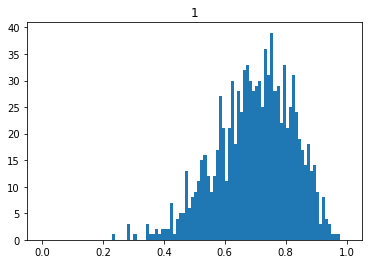

0


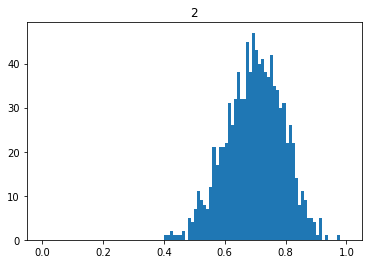

0


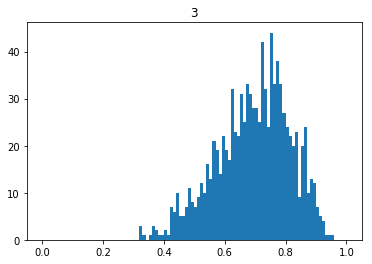

2.0


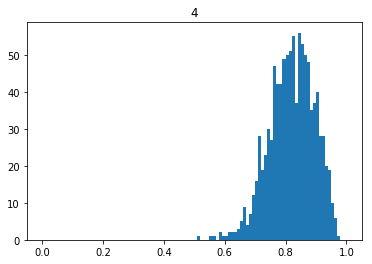

1.0


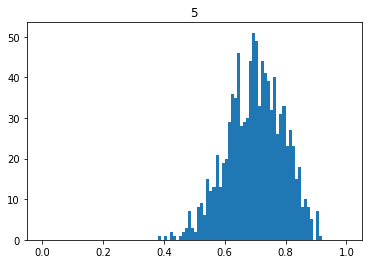

1.0


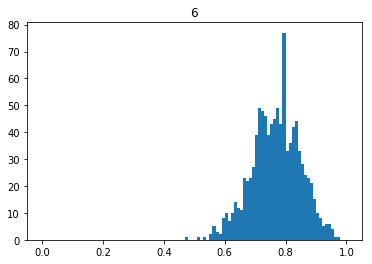

4.0


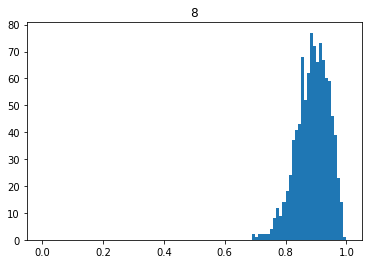

3.0


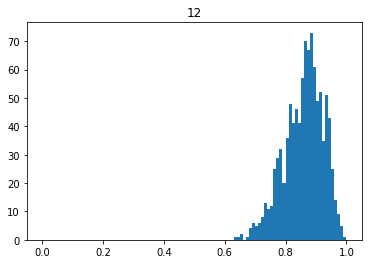

6.0


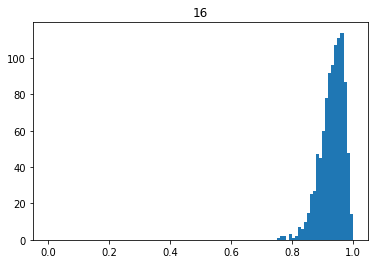

5.0


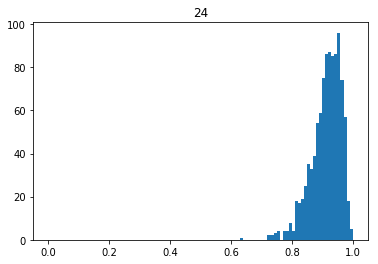

8.0


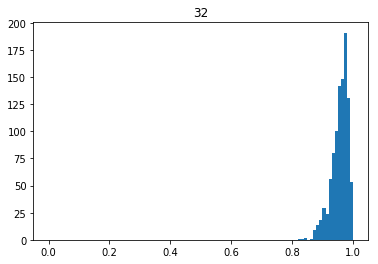

7.0


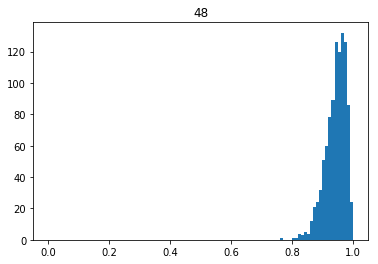

10.0


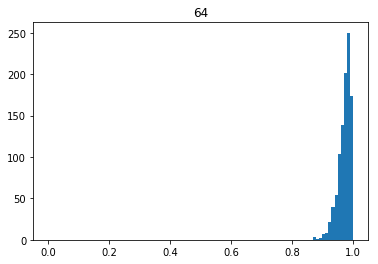

9.0


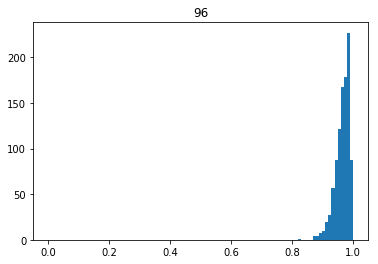

11.0


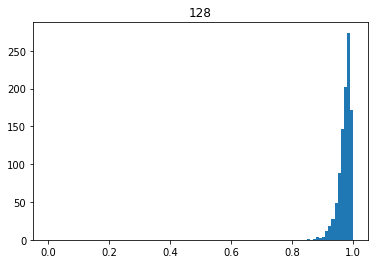

In [105]:
for qubit in fidelities:
    print(dis[qubit])
    plt.hist(fidelities[qubit], range = (0, 1), bins = 100)
    plt.title(str(qubit))
    plt.show()

In [127]:
xs = []
ys = []
for qubit in fidelities:
    #print(dis[qubit])
    #print(fidelities[qubit].mean())
    xs.append(dis[qubit])
    ys.append(fidelities[qubit].mean())

In [128]:
zs = list(zip(xs,ys))
zs = sorted(zs)
xs, ys = list(zip(*zs))
xs = np.array(xs)
ys = np.array(ys)

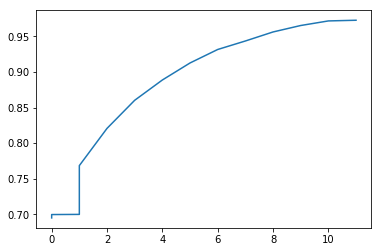

In [129]:
# distance from support vs fidelity
plt.plot(xs, ys)

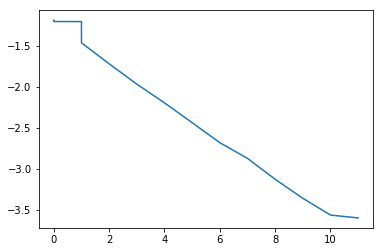

In [130]:
# distance from support vs log(1-fidelity)
plt.plot(xs, np.log(1-ys))

# Do not delete

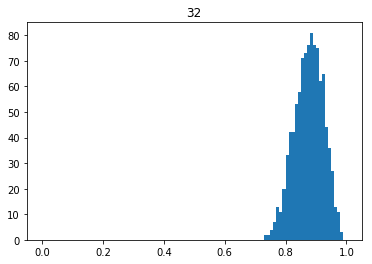

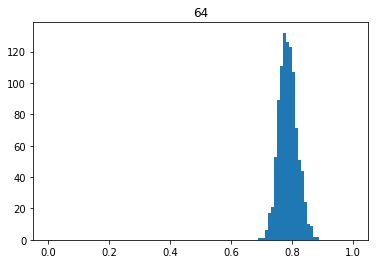

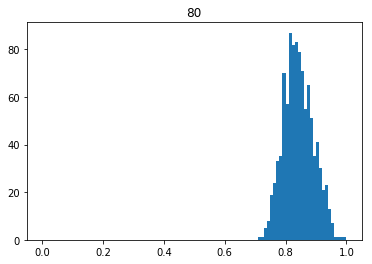

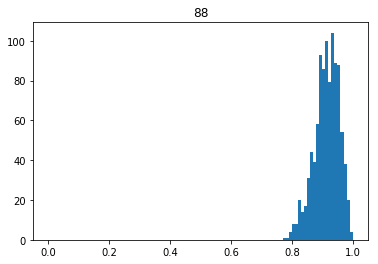

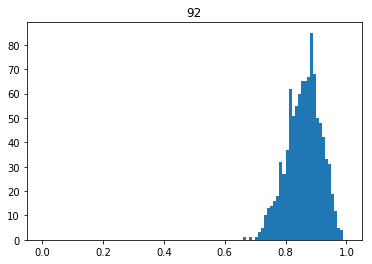

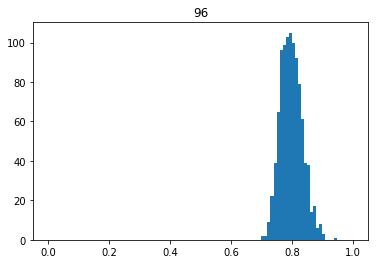

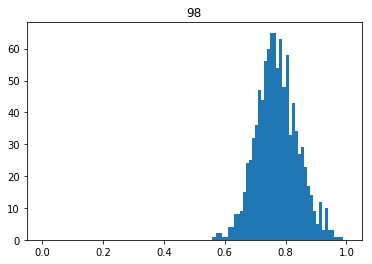

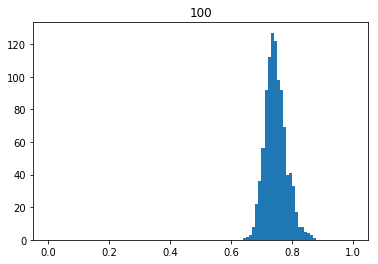

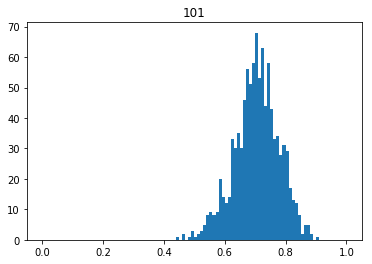

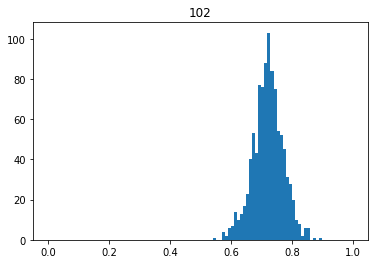

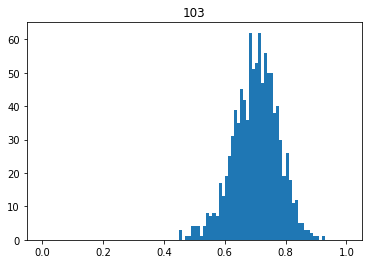

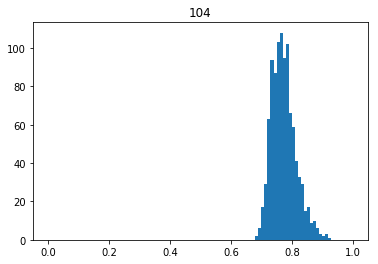

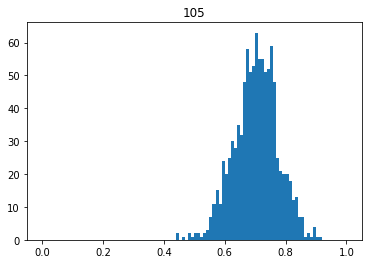

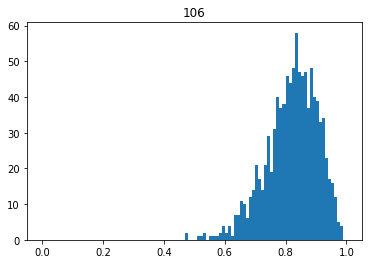

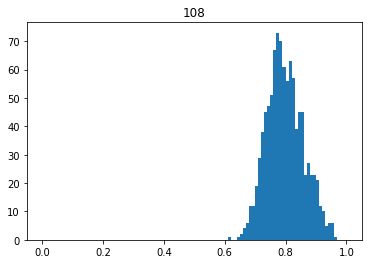

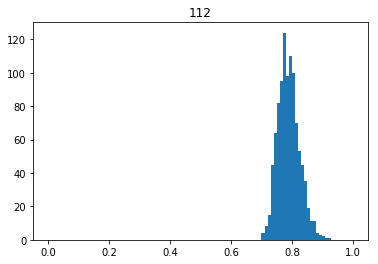

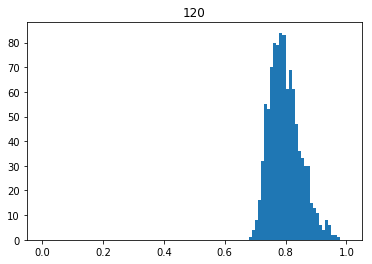

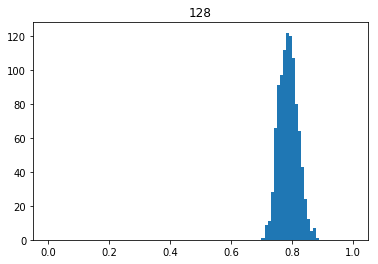

In [54]:
for qubit in fidelities:
    plt.hist(fidelities[qubit], range = (0, 1), bins = 100)
    plt.title(str(qubit))
    plt.show()

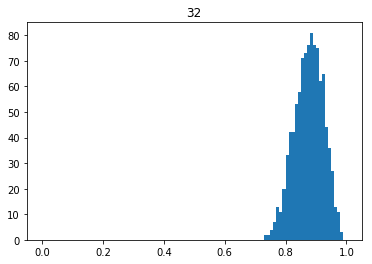

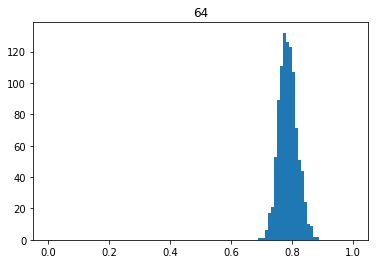

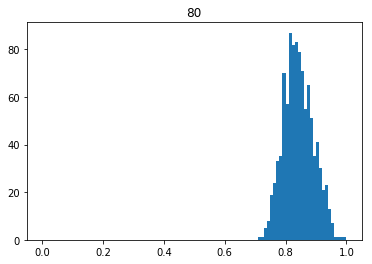

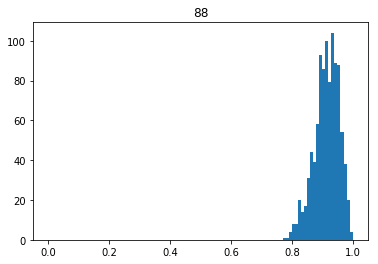

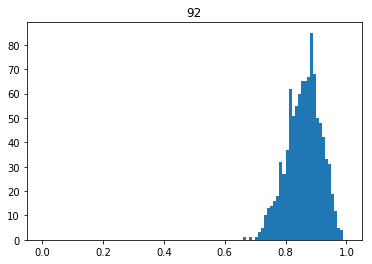

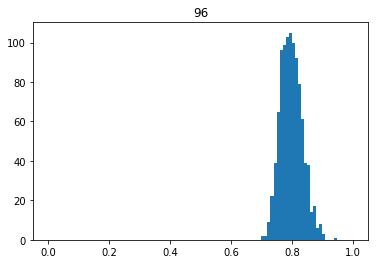

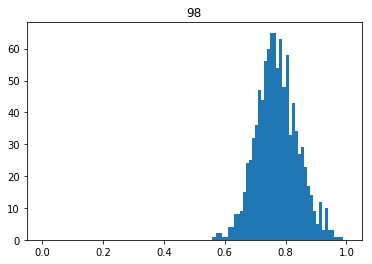

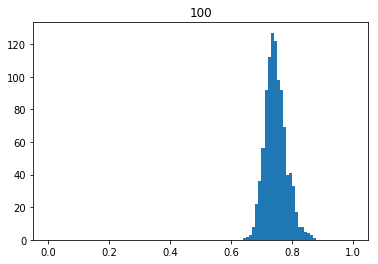

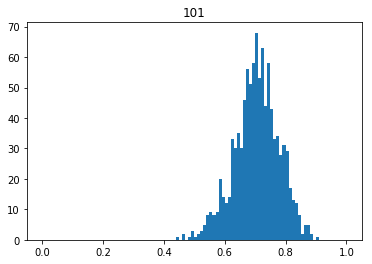

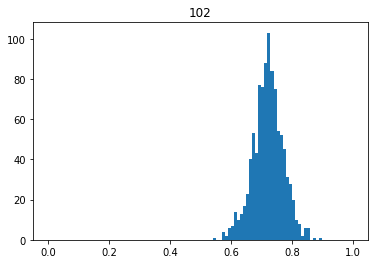

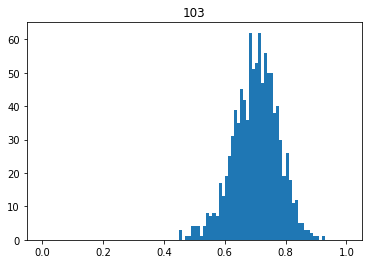

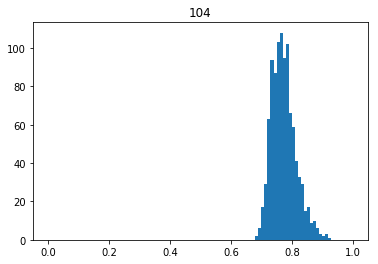

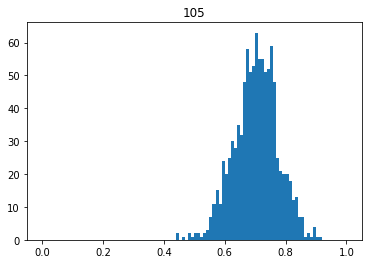

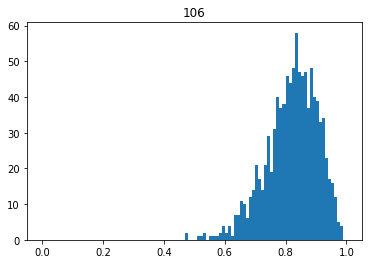

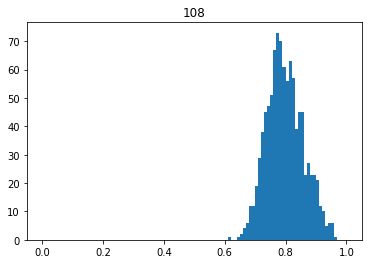

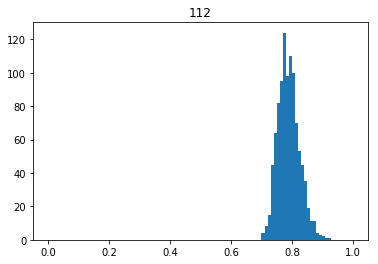

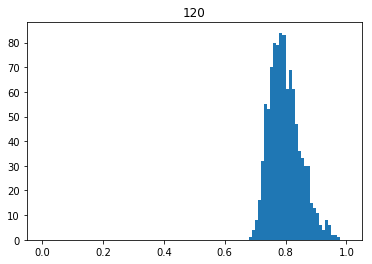

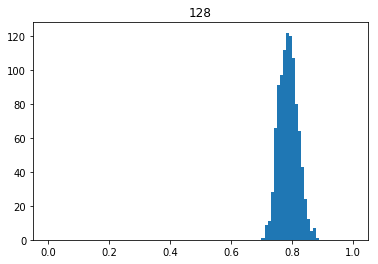

In [54]:
for qubit in fidelities:
    plt.hist(fidelities[qubit], range = (0, 1), bins = 100)
    plt.title(str(qubit))
    plt.show()